Imports

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from xgboost import XGBRegressor

Read, Initial Analysis

In [31]:
df = pd.read_csv("diabetes.csv")
print(df.head())
print('------------------statistical measures---------------------------------')
print(df.describe())
print('--------------------rows and columns-------------------------------')
print(df.shape)
#There's no null values

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
------------------statistical measures---------------------------------
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std

In [32]:
print("-------------------Data Info-------------------")
print(df.info())
print("-------------------Matrix Correlation-------------------")
print(df.corr())

-------------------Data Info-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
-------------------Matrix Correlation-------------------
                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459  

No nules values | Only numeric data types
Glucose - BMI - Age - Pregnancies --> Features with higher correlation

Graphics to clarify data

C:\Users\PC\AppData\Local\Temp\ipykernel_10356\4192882748.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette="viridis")


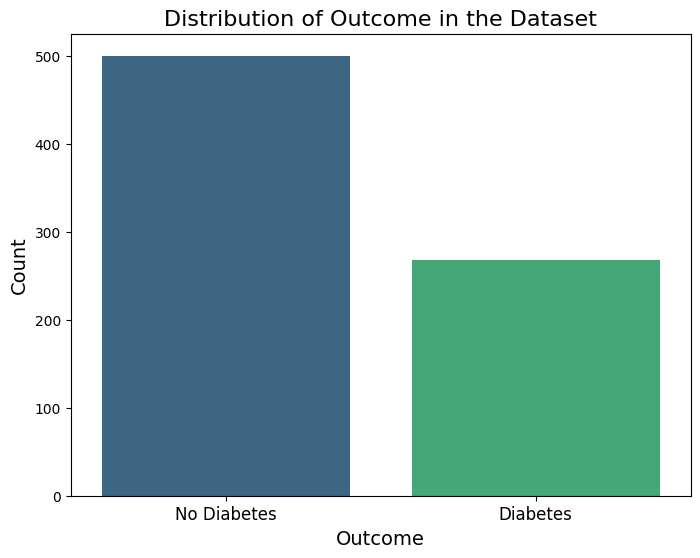

In [33]:
outcome_counts = df['Outcome'].value_counts()
# Bars plot
plt.figure(figsize=(8, 6))
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette="viridis")
plt.xlabel("Outcome", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Outcome in the Dataset", fontsize=16)
plt.xticks([0, 1], labels=["No Diabetes", "Diabetes"], fontsize=12)
plt.show()


In [34]:
df.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


Pacients with Diabetes has higher mean value in each variable 

Set X,y and Correlation 

In [35]:
df = df.drop(columns=["DiabetesPedigreeFunction"])
## Delete this column, it's not clear utility
#Target vs Featured Variables
y = df.Outcome
#['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age']
X= df.drop(columns='Outcome',axis=1)
print('Correlation with OutCome:\n')
print(X.corrwith(y))


Correlation with OutCome:

Pregnancies      0.221898
Glucose          0.466581
BloodPressure    0.065068
SkinThickness    0.074752
Insulin          0.130548
BMI              0.292695
Age              0.238356
dtype: float64


As expected Glucose a strong relationship with the target (Outcome)

#### Data Standardization

In [36]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X[0:5])

[[ 0.63994726  0.84832379  0.14964075  0.90726993 -0.69289057  0.20401277
   1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575  0.53090156 -0.69289057 -0.68442195
  -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 -1.28821221 -0.69289057 -1.10325546
  -0.10558415]
 [-0.84488505 -0.99820778 -0.16054575  0.15453319  0.12330164 -0.49404308
  -1.04154944]
 [-1.14185152  0.5040552  -1.50468724  0.90726993  0.76583594  1.4097456
  -0.0204964 ]]


### Data Split

In [37]:
X_train,X_val,y_train,y_val = train_test_split(X,y,
                                               random_state=24,
                                               train_size=0.3,
                                               stratify=y)
#Check
print(X.shape, X_train.shape, X_val.shape)

(768, 7) (230, 7) (538, 7)


### SVM Model

In [38]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], #how much wrong predictions affect the solution (differents hiperplanes)
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], #influence of one training point
              'kernel': ['rbf']}
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train, y_train) #try all combinations

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.674 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

Best parameters after tuning and hyper-parameter tuning

In [39]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)


Setting the model

In [40]:
best_svm_model = grid.best_estimator_

#### SVM Model Evaluation


In [41]:
# accuracy score on the training data
X_train_pred = best_svm_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_pred, y_train)
print('Accuracy score(training data): ', training_data_accuracy)

Accuracy score(training data):  0.8043478260869565


In [42]:
# accuracy score on the test data
X_val_pred = best_svm_model.predict(X_val)
val_data_accuracy = accuracy_score(X_val_pred, y_val)
print('Accuracy score of the validation data : ', val_data_accuracy)

Accuracy score of the validation data :  0.7434944237918215


In [43]:
print(classification_report(y_val, X_val_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       350
           1       0.70      0.47      0.56       188

    accuracy                           0.74       538
   macro avg       0.73      0.68      0.69       538
weighted avg       0.74      0.74      0.73       538



### XGBoost Model

In [44]:

model_xg = XGBRegressor(random_state=40, n_estimators=800, learning_rate=0.5,early_stopping_rounds=10,eval_metric="mae")
model_xg.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], 
             verbose=False)
predictions = model_xg.predict(X_val)

#### XGBoost Evaluation

Mean Absolute Error: 0.3054634630680084


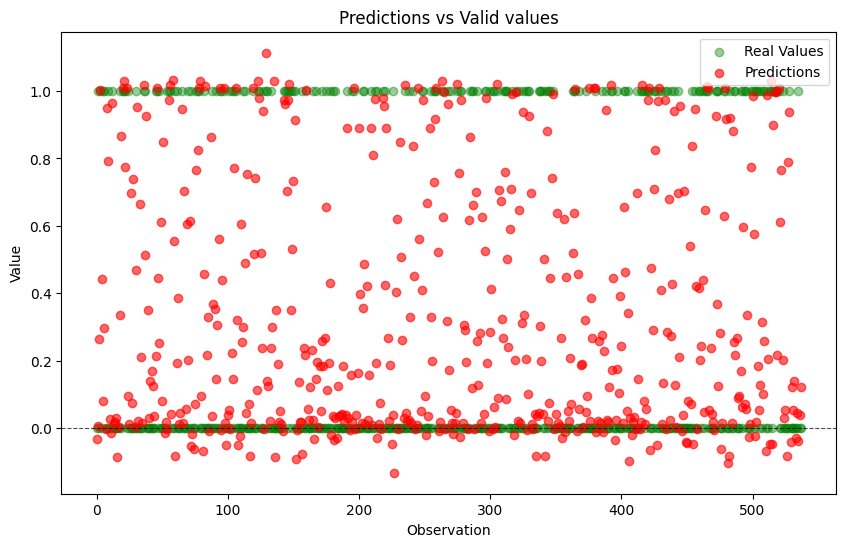

Accuracy: 0.7174721189591078
Matrix confusion
 [[286  64]
 [ 88 100]]
Precision score: 0.6097560975609756
Recall: 0.5319148936170213
F1 Score: 0.5681818181818182
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       350
           1       0.61      0.53      0.57       188

    accuracy                           0.72       538
   macro avg       0.69      0.67      0.68       538
weighted avg       0.71      0.72      0.71       538



In [ ]:
mae = mean_absolute_error(predictions,y_val) 
print("Mean Absolute Error:" , mae)
    # No sense with binary predictions
    #plt.figure(figsize=(10, 6))
    #plt.scatter(range(len(y_val)), y_val, color="green", label="Real Values", alpha=0.4)
    #plt.scatter(range(len(predictions)), predictions, color="red", label="Predictions", alpha=0.6)
    #plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8, alpha=0.7)
    #plt.title("Predictions vs Valid values")
    #plt.xlabel("Observation")
    #plt.ylabel("Value")
    #plt.legend()
    #plt.show()
# Tranform continuos predictions to binary (0,1)
binary_predictions = (predictions >= 0.5).astype(int)
accuracy = accuracy_score(y_val, binary_predictions)
print(f"Accuracy: {accuracy}")

print('Matrix confusion\n',confusion_matrix(y_val, binary_predictions))
#True Negatives | False Positives
#False Negatives | True Positivies

print(f"Precision score: {precision_score(y_val, binary_predictions)}") #Positive Predictive Value
print(f"Recall: {recall_score(y_val, binary_predictions)}") #Sensitivity o True Positive Rate
print(f"F1 Score: {f1_score(y_val, binary_predictions)}") # Precision and Recall combined
report = classification_report(y_val, binary_predictions)
print(report)

### Prediction pipeline example

In [55]:

def run_diabetes_prediction_pipeline(input_data):
    # changing the input_data to numpy array
    input_data_as_numpy_array = np.asarray(input_data)

    # reshape the array as we are predicting for one instance
    input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

    # standardize the input data
    std_data = scaler.transform(input_data_reshaped)
    print(std_data)
    prediction_svm = best_svm_model.predict(std_data)
    prediction_xgboost = model_xg.predict(std_data)
    if prediction_svm[0] == 0:
        print('Prediction SVM Model: The person is not diabetic')
    else: print('The person is diabetic for SVM Model')

    if prediction_xgboost[0] == 0:
        print('Prediction XGBoost Model: The person is not diabetic')
    else: print('The person is diabetic for XGBoost Model')
    


In [60]:
test_input= (1,156,70,30,160,28.8,43)
#['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age']
print(run_diabetes_prediction_pipeline(test_input))

[[-0.84488505  1.09870096  0.04624525  0.59362962  0.69637278 -0.40519961
   0.83038113]]
Prediction SVM Model: The person is not diabetic
The person is diabetic for XGBoost Model
None


c:\Users\PC\Desktop\Proyectos\DiabetesPrediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
